<a href="https://colab.research.google.com/github/PunitRaveendran/ACM/blob/main/Book%20dropout%20predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phase 1


Epoch [1/10], Loss: 0.0000
Epoch [2/10], Loss: 0.0000
Epoch [3/10], Loss: 0.0000
Epoch [4/10], Loss: 0.0000
Epoch [5/10], Loss: 0.0000
Epoch [6/10], Loss: 0.0000
Epoch [7/10], Loss: 0.0000
Epoch [8/10], Loss: 0.0000
Epoch [9/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000

Evaluating the model...
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Plotting training loss...


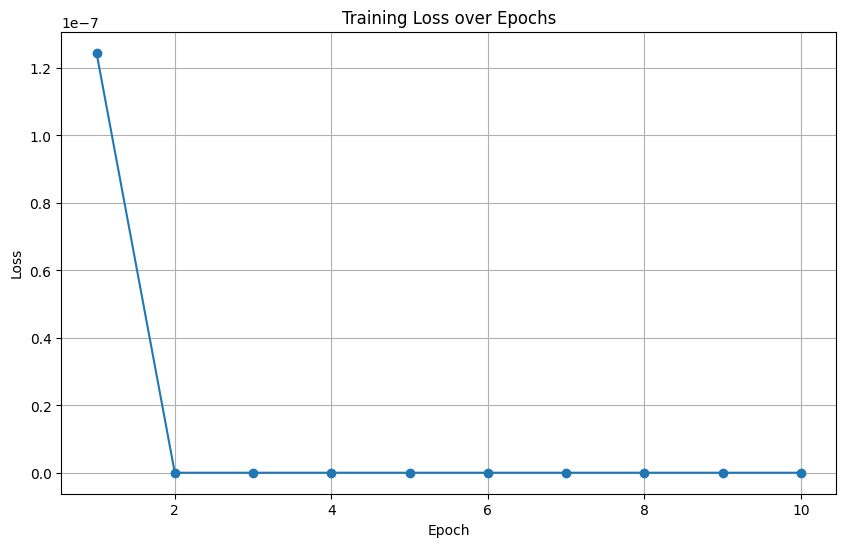

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import zipfile

try:
    with zipfile.ZipFile('archive.zip', 'r') as z:
        books_df = pd.read_csv(z.open('books.csv'))
        ratings_df = pd.read_csv(z.open('ratings.csv'))
        to_read_df = pd.read_csv(z.open('to_read.csv'))
        book_tags_df = pd.read_csv(z.open('book_tags.csv'))
        tags_df = pd.read_csv(z.open('tags.csv'))

except FileNotFoundError:
    print("Error: archive.zip not found. Please ensure the file is accessible.")
    exit()
except KeyError as e:
    print(f"Error: File not found within the zip archive: {e}. Please check the file names and paths inside the zip.")
    exit()


# Filtering out books with missing essential information
books_df.dropna(subset=['original_publication_year', 'average_rating', 'ratings_count'], inplace=True)

# now we merge books with tags to get genre information
book_tags_df = book_tags_df.merge(tags_df, on='tag_id')

# then the top 100 most popular tags (genres) to use as features
popular_tags = book_tags_df['tag_name'].value_counts().nlargest(100).index
book_tags_filtered = book_tags_df[book_tags_df['tag_name'].isin(popular_tags)]

genre_features = book_tags_filtered.pivot_table(index='goodreads_book_id', columns='tag_name', values='count', fill_value=0)
genre_features = genre_features.reset_index().rename(columns={'goodreads_book_id': 'book_id'})

# Merge book metadata with genre features
books_with_genres_df = books_df.merge(genre_features, on='book_id', how='left')
books_with_genres_df.fillna(0, inplace=True)  # Filling NaNs for books without any popular tags

# Label Creation
# Create a unique identifier for each user-book interaction
ratings_df['user_book_id'] = ratings_df['user_id'].astype(str) + '_' + ratings_df['book_id'].astype(str)
to_read_df['user_book_id'] = to_read_df['user_id'].astype(str) + '_' + to_read_df['book_id'].astype(str)

# Create a DataFrame for "finished" books (label = 1) from the ratings data
finished_books_df = ratings_df.copy()
finished_books_df['label'] = 1

# Creating a DataFrame for "dropped" books (label = 0)
# A book is considered dropped if it's in the to_read list but not in the ratings list
rated_user_book_ids = set(ratings_df['user_book_id'])
dropped_books_df = to_read_df[~to_read_df['user_book_id'].isin(rated_user_book_ids)].copy()
dropped_books_df['label'] = 0

# Merging the finished and dropped datasets
dataset_df = pd.concat([finished_books_df, dropped_books_df], ignore_index=True)
# Merge with book features
final_df = dataset_df.merge(
    books_with_genres_df, on='book_id', how='left'
)
final_df.dropna(inplace=True) # Drop any rows where book features were not found
# Feature and Label Preparation for PyTorch
# Select numerical and genre features
numerical_features = ['average_rating', 'ratings_count', 'work_ratings_count', 'work_text_reviews_count', 'original_publication_year', 'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5']
genre_features_list = popular_tags.tolist()

# Add the user's rating as a feature for the finished books
final_df['user_rating'] = final_df['rating'].fillna(0)
features_list = numerical_features + genre_features_list + ['user_rating']

X = final_df[features_list].values
y = final_df['label'].values

# Standardize numerical features
scaler = StandardScaler()
X[:, :len(numerical_features)] = scaler.fit_transform(X[:, :len(numerical_features)])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create a custom PyTorch Dataset
class DropoutDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = DropoutDataset(X_train_tensor, y_train_tensor)
test_dataset = DropoutDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#Model Definition
# Multilayer Perceptron with ReLU hidden layers and Sigmoid output
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.output_layer = nn.Linear(64, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        # We don't apply Sigmoid here, we use BCEWithLogitsLoss which combines Sigmoid and Binary Cross Entropy
        x = self.output_layer(x)
        return x

# Initialize the model, loss function, and optimizer
input_size = X_train_tensor.shape[1]
model = MLP(input_size)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Model Training
num_epochs = 10
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for features, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * features.size(0)

    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
# Model Evaluation
print("\nEvaluating the model...")
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)
        predictions = (torch.sigmoid(outputs) > 0.5).int()
        all_predictions.extend(predictions.numpy().flatten())
        all_labels.extend(labels.numpy().flatten())

accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

#Loss Visualization
print("\nPlotting training loss...")
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()